In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [26]:
# Actual labels
y_true = ['Ripe'] * 13 + ['Overripe'] * 12 + ['Plastic'] * 13

# Predicted labels 
y_pred = ['Ripe'] * 13 + ['Ripe'] * 6 + ['Overripe'] * 6 + ['Plastic'] * 13

# Classes
classes = ['Ripe', 'Overripe', 'Plastic']

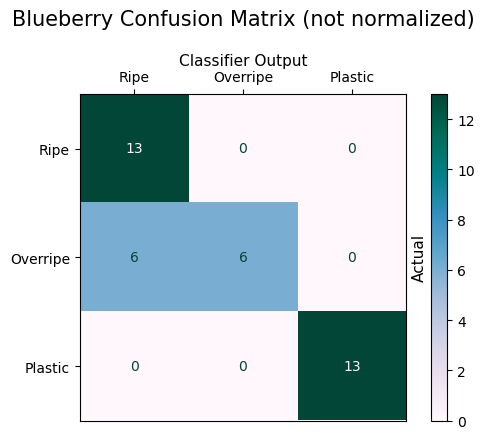

<Figure size 640x480 with 0 Axes>

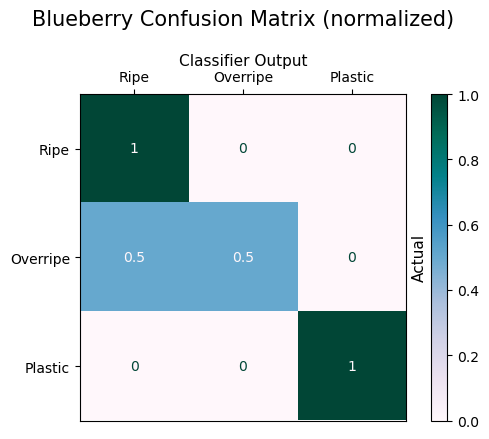

              precision    recall  f1-score   support

        Ripe       1.00      0.50      0.67        12
    Overripe       1.00      1.00      1.00        13
     Plastic       0.68      1.00      0.81        13

    accuracy                           0.84        38
   macro avg       0.89      0.83      0.83        38
weighted avg       0.89      0.84      0.83        38



In [44]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
cm_norm = confusion_matrix(y_true, y_pred, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(cmap=plt.cm.PuBuGn)
plt.title('Blueberry Confusion Matrix (not normalized)', fontsize=15, pad=20)
plt.xlabel('Classifier Output', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().yaxis.set_label_position('right')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.figure()
disp_norm.plot(cmap=plt.cm.PuBuGn)
plt.title('Blueberry Confusion Matrix (normalized)', fontsize=15, pad=20)
plt.xlabel('Classifier Output', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().yaxis.set_label_position('right')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.show()
print(classification_report(y_true, y_pred, target_names=classes))